## Step 1 - Customer Retention EDA

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [67]:
df = pd.read_csv('../datafiles/CO_2014_2015.csv')
df.head()

,Age,StateProvinceCode,CustomerLifetimeSpend,Customer1YearSpend,Customer3YearSpend,ThreeYearVisitCount,SkiLoyaltyIndexRating,FrontRangeMarket,CustId,Spend_Winter_2010,...,April_15,November_14,December_14,Total_Days_14_15,Total_Days_13_14,Ski_Resort1_2014_2015,Ski_Resort2_2014_2015,Ski_Resort3_2014_2015,Ski_Resort4_2014_2015,Ski_Resort5_2014_2015
0,42,CO,55.61,0.0,42.43,19,10.0,1,1073873,0.0,...,0,0,1,7,0,0,0,0,0,7
1,48,CO,139.00,0.0,139.00,24,0.0,1,1073874,0.0,...,0,0,0,2,2,0,0,2,0,0
2,48,CO,428.00,0.0,0.00,13,0.0,1,1073876,59.0,...,0,0,0,2,4,0,0,1,0,1
3,33,CO,449.00,0.0,0.00,0,0.0,0,1073942,0.0,...,0,0,0,0,0,0,0,0,0,0
4,24,CO,148.19,0.0,148.19,2,0.0,1,1073956,0.0,...,0,1,0,4,0,0,0,0,0,4


#### A glimpse into all of the columns formatted from the Data Warehouse

In [68]:
df.columns

Index(['Age', 'StateProvinceCode', 'CustomerLifetimeSpend',
       'Customer1YearSpend', 'Customer3YearSpend', 'ThreeYearVisitCount',
       'SkiLoyaltyIndexRating', 'FrontRangeMarket', 'CustId',
       'Spend_Winter_2010', 'Spend_Winter_2011', 'Spend_Winter_2012',
       'Spend_Winter_2013', 'Spend_Winter_2014', 'Spend_Winter_2015',
       'Household1YearSpend', 'Household3YearSpend', 'HouseholdLifetimeSpend',
       'NumberOfHouseholdMembers', 'NumberOfAdults', 'NumberOfChildren',
       'Pass_Winter_2010', 'Pass_Winter_2011', 'Pass_Winter_2012',
       'Pass_Winter_2013', 'Pass_Winter_2014', 'Pass_Winter_2015',
       'CustomerId', 'Early_Purchase_2014_2015', 'Regular_Purchase_2014_2015',
       'Late_Purchase_2014_2015', 'Super_Late_Purchase_2014_2015',
       'January_15', 'February_15', 'March_15', 'April_15', 'November_14',
       'December_14', 'Total_Days_14_15', 'Total_Days_13_14',
       'Ski_Resort1_2014_2015', 'Ski_Resort2_2014_2015',
       'Ski_Resort3_2014_2015', 'Ski_R

#### All numeric except StateProvinceCode which is limited to 'CO' and removed from the model. I also removed ZipCode and CustId.

In [69]:
df.dtypes

Age                                int64
StateProvinceCode                 object
CustomerLifetimeSpend            float64
Customer1YearSpend               float64
Customer3YearSpend               float64
ThreeYearVisitCount                int64
SkiLoyaltyIndexRating            float64
FrontRangeMarket                   int64
CustId                             int64
Spend_Winter_2010                float64
Spend_Winter_2011                float64
Spend_Winter_2012                float64
Spend_Winter_2013                float64
Spend_Winter_2014                float64
Spend_Winter_2015                float64
Household1YearSpend              float64
Household3YearSpend              float64
HouseholdLifetimeSpend           float64
NumberOfHouseholdMembers           int64
NumberOfAdults                     int64
NumberOfChildren                   int64
Pass_Winter_2010                   int64
Pass_Winter_2011                   int64
Pass_Winter_2012                   int64
Pass_Winter_2013

In [70]:
df.shape

(139616, 45)

#### All Nulls were cleaned up in the SQL Layer

In [71]:
df.isnull().sum()

Age                              0
StateProvinceCode                0
CustomerLifetimeSpend            0
Customer1YearSpend               0
Customer3YearSpend               0
ThreeYearVisitCount              0
SkiLoyaltyIndexRating            0
FrontRangeMarket                 0
CustId                           0
Spend_Winter_2010                0
Spend_Winter_2011                0
Spend_Winter_2012                0
Spend_Winter_2013                0
Spend_Winter_2014                0
Spend_Winter_2015                0
Household1YearSpend              0
Household3YearSpend              0
HouseholdLifetimeSpend           0
NumberOfHouseholdMembers         0
NumberOfAdults                   0
NumberOfChildren                 0
Pass_Winter_2010                 0
Pass_Winter_2011                 0
Pass_Winter_2012                 0
Pass_Winter_2013                 0
Pass_Winter_2014                 0
Pass_Winter_2015                 0
CustomerId                       0
Early_Purchase_2014_

### Below are sections where I explain the features and demonstrate the EDA via SQL executed against the database. As you will see, some of these columns are from the DW and others were calculated via SQL.

#### The data for this analysis was limited to StateProvinceCode = 'CO' and ProductFamily = 'Paid Pass'. The reason is that I wanted to limit the analysis to the Colorado market and just analyze Pass retention. There is certainly potential to expand the use case given the data available.

#### Customer Demographics around Spend, Location, and Loyalty (which was already calculated in the DW)

```SQL
CREATE VIEW v_Customer  
AS  
SELECT C.Age, C.[StateProvinceCode], C.CustomerLifetimeSpend, C.Customer1YearSpend, C.Customer3YearSpend,
       ISNULL(C.[ThreeYearVisitCount],0) as [ThreeYearVisitCount],
       ISNULL(C.SkiLoyaltyIndexRating,0) as SkiLoyaltyIndexRating,
	   ISNULL(C.[FrontRangeMarket],1) as [FrontRangeMarket] , C.CustomerId as CustId, 
	   ISNULL(CNP.[Winter 2010/2011],0) as [Spend_Winter_2010],
	   ISNULL(CNP.[Winter 2011/2012],0) as [Spend_Winter_2011],
	   ISNULL(CNP.[Winter 2012/2013],0) as [Spend_Winter_2012],
	   ISNULL(CNP.[Winter 2013/2014],0) as [Spend_Winter_2013],
	   ISNULL(CNP.[Winter 2014/2015],0) as [Spend_Winter_2014],
	   ISNULL(CNP.[Winter 2015/2016],0) as [Spend_Winter_2015],
	   HH.[Household1YearSpend], HH.[Household3YearSpend], HH.[HouseholdLifetimeSpend], 
	   ISNULL(HH.[NumberOfHouseholdMembers],1) as [NumberOfHouseholdMembers], ISNULL(HH.[NumberOfAdults],1) as [NumberOfAdults], 
	   ISNULL(HH.[NumberOfChildren],0) as [NumberOfChildren],
	   CASE WHEN CP.[Winter 2010/2011] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2010],
	   CASE WHEN CP.[Winter 2011/2012] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2011],
	   CASE WHEN CP.[Winter 2012/2013] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2012],
	   CASE WHEN CP.[Winter 2013/2014] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2013],
	   CASE WHEN CP.[Winter 2014/2015] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2014],
	   CASE WHEN CP.[Winter 2015/2016] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2015],
	   CPT.*
FROM [dbo].[DimCustomer] as C JOIN [dbo].[v_Customer_Pass] as CP
  ON C.CustomerId = CP.[CustomerId] LEFT JOIN [dbo].[v_Customer_non_Pass] as CNP
  ON C.CustomerId = CNP.[CustomerId] JOIN [dbo].[DimHousehold] as HH
  ON C.HouseholdId = HH.HouseholdId LEFT JOIN [dbo].[v_Customer_Pass_Timing] as CPT
  ON C.CustomerId = CPT.CustomerId
  ```

In [72]:
df[['CustId','StateProvinceCode','CustomerLifetimeSpend','Customer1YearSpend', 
    'Customer3YearSpend', 'ThreeYearVisitCount','SkiLoyaltyIndexRating', 'FrontRangeMarket']].head(10)

,CustId,StateProvinceCode,CustomerLifetimeSpend,Customer1YearSpend,Customer3YearSpend,ThreeYearVisitCount,SkiLoyaltyIndexRating,FrontRangeMarket
0,1073873,CO,55.61,0.00,42.43,19,10.00,1
1,1073874,CO,139.00,0.00,139.00,24,0.00,1
2,1073876,CO,428.00,0.00,0.00,13,0.00,1
3,1073942,CO,449.00,0.00,0.00,0,0.00,0
4,1073956,CO,148.19,0.00,148.19,2,0.00,1
5,1073958,CO,1164.62,498.94,1164.62,15,10.00,1
6,1074190,CO,11881.66,6770.61,8958.41,13,10.00,1
7,1074240,CO,409.00,0.00,0.00,0,10.00,1
8,1074242,CO,504.62,0.00,0.00,0,10.00,1
9,1074310,CO,3069.51,675.51,1293.51,6,7.36,1


#### All of these columns are calculated Spend that was not on Pass Purchases

```SQL
CREATE VIEW v_Customer_non_Pass 
AS  
select * from (select [CustomerId], SeasonName,  [Price] from v_Sales where IsDeleted = 'False' and ProductFamily <> 'Paid Pass') src 
pivot ( sum([Price]) for SeasonName in ([Winter 2010/2011] , [Winter 2011/2012] , [Winter 2012/2013] , [Winter 2013/2014] , [Winter 2014/2015], [Winter 2015/2016])) piv
```

In [73]:
df[['CustId','Spend_Winter_2010', 'Spend_Winter_2011', 'Spend_Winter_2012',
    'Spend_Winter_2013', 'Spend_Winter_2014', 'Spend_Winter_2015']].head(10)

,CustId,Spend_Winter_2010,Spend_Winter_2011,Spend_Winter_2012,Spend_Winter_2013,Spend_Winter_2014,Spend_Winter_2015
0,1073873,0.0,0.0,0.0,0.0,0.0,0.0
1,1073874,0.0,0.0,199.0,0.0,139.0,0.0
2,1073876,59.0,0.0,0.0,0.0,0.0,0.0
3,1073942,0.0,0.0,0.0,0.0,0.0,0.0
4,1073956,0.0,0.0,0.0,0.0,138.0,0.0
5,1073958,0.0,0.0,0.0,49.0,0.0,0.0
6,1074190,0.0,0.0,0.0,0.0,0.0,457.0
7,1074240,0.0,0.0,0.0,0.0,0.0,0.0
8,1074242,0.0,407.0,0.0,0.0,0.0,0.0
9,1074310,59.0,0.0,307.0,0.0,69.0,0.0


#### All of the Customers rollup to a Household in the DW. I included some of those columns in the dataset to help with the predictions. In the future, I would also like to expand the analysis to the Household level and determine the impact a Household has on Pass renewals, but for now just focused at the Customer level.

```SQL
CREATE VIEW v_Customer  
AS  
SELECT C.Age, C.[StateProvinceCode], C.CustomerLifetimeSpend, C.Customer1YearSpend, C.Customer3YearSpend,
       ISNULL(C.[ThreeYearVisitCount],0) as [ThreeYearVisitCount],
       ISNULL(C.SkiLoyaltyIndexRating,0) as SkiLoyaltyIndexRating,
	   ISNULL(C.[FrontRangeMarket],1) as [FrontRangeMarket] , C.CustomerId as CustId, 
	   ISNULL(CNP.[Winter 2010/2011],0) as [Spend_Winter_2010],
	   ISNULL(CNP.[Winter 2011/2012],0) as [Spend_Winter_2011],
	   ISNULL(CNP.[Winter 2012/2013],0) as [Spend_Winter_2012],
	   ISNULL(CNP.[Winter 2013/2014],0) as [Spend_Winter_2013],
	   ISNULL(CNP.[Winter 2014/2015],0) as [Spend_Winter_2014],
	   ISNULL(CNP.[Winter 2015/2016],0) as [Spend_Winter_2015],
	   HH.[Household1YearSpend], HH.[Household3YearSpend], HH.[HouseholdLifetimeSpend], 
	   ISNULL(HH.[NumberOfHouseholdMembers],1) as [NumberOfHouseholdMembers], ISNULL(HH.[NumberOfAdults],1) as [NumberOfAdults], 
	   ISNULL(HH.[NumberOfChildren],0) as [NumberOfChildren],
	   CASE WHEN CP.[Winter 2010/2011] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2010],
	   CASE WHEN CP.[Winter 2011/2012] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2011],
	   CASE WHEN CP.[Winter 2012/2013] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2012],
	   CASE WHEN CP.[Winter 2013/2014] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2013],
	   CASE WHEN CP.[Winter 2014/2015] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2014],
	   CASE WHEN CP.[Winter 2015/2016] >= 1 THEN 1 ELSE 0 END as [Pass_Winter_2015],
	   CPT.*
FROM [dbo].[DimCustomer] as C JOIN [dbo].[v_Customer_Pass] as CP
  ON C.CustomerId = CP.[CustomerId] LEFT JOIN [dbo].[v_Customer_non_Pass] as CNP
  ON C.CustomerId = CNP.[CustomerId] JOIN [dbo].[DimHousehold] as HH
  ON C.HouseholdId = HH.HouseholdId LEFT JOIN [dbo].[v_Customer_Pass_Timing] as CPT
  ON C.CustomerId = CPT.CustomerId
  ```

In [74]:
df[['CustId','Household1YearSpend','Household3YearSpend', 'HouseholdLifetimeSpend',
    'NumberOfHouseholdMembers', 'NumberOfAdults','NumberOfChildren']].head(10)

,CustId,Household1YearSpend,Household3YearSpend,HouseholdLifetimeSpend,NumberOfHouseholdMembers,NumberOfAdults,NumberOfChildren
0,1073873,871.90,2724.82,2924.29,4,2,2
1,1073874,970.00,3679.74,3876.74,4,2,2
2,1073876,945.58,2774.44,2872.44,3,3,0
3,1073942,0.00,0.00,0.00,2,2,0
4,1073956,0.00,148.19,386.19,2,2,0
5,1073958,1176.88,2382.10,2382.10,2,2,0
6,1074190,6943.37,12474.10,12474.10,4,2,2
7,1074240,0.00,0.00,0.00,1,1,0
8,1074242,0.00,0.00,0.00,2,2,0
9,1074310,675.51,1293.51,2160.51,1,1,0


#### I flattened out the MountainAccessSales table which is organized by Customer, transaction date, and SeasonName, to get a binary classification of purchasing a Pass for that Season or not. Please note that the field name determines the SeasonName. For example, Pass_Winter_2010 is purchasing a Pass for the 2010/2011 season, which runs from November 2010 to April 2011. 

```SQL
CREATE VIEW v_Sales  
AS  
SELECT S.[SourceSystemName], S.[Quantity], S.[Price], S.[HasResortCharge], S.[PriceInCorporateCurrency],
	   S.[TotalUsageDays], S.[PurchaserCustomerId], S.[ProductOwnerCustomerId], S.ProductId,
	   D.CalendarDate, Se.SeasonName, PP.ProductPackageName, L.LocationName, L.LocationType,
	   P.ProductClass, P.ProductFamily, P.ProductName, P.ProductType, C.CountryCode,
	   C.Age, C.City, C.[StateProvinceCode], C.[PostalCode], C.CustomerLifetimeSpend, C.Customer1YearSpend, C.Customer3YearSpend,
	   C.IsDeleted, C.[ThreeYearVisitCount], C.SkiAbility, C.[NearestMajorAirportCode], C.SkiLoyaltyIndexRating,
	   C.[IsWinterGuest], C.[IsSummerGuest], C.[FrontRangeMarket], C.CustomerId
FROM [dbo].[MountainAccessSales] as S JOIN [dbo].[DimDate] as D
  ON S.SaleDateId = D.DateId JOIN [dbo].[DimSeason] as Se
  ON S.SeasonId = Se.SeasonId  LEFT JOIN [dbo].[v_Product] as P
  ON S.ProductId = P.ProductId LEFT JOIN [dbo].[DimProductPackage] as PP
  ON S.[ProductPackageId] = PP.ProductPackageId LEFT JOIN [dbo].[DimLocation] as L
  ON S.FulfillmentLocationId = L.[LocationId] JOIN [dbo].[DimCustomer] as C
  ON S.[ProductOwnerCustomerId] = C.CustomerId
WHERE C.IsDeleted = 'False'
```

#### Ultimately, in my model I am trying to predict the value for Pass_Winter_2015. The models could be retrofitted for previous years, as well as going forward, but my data ends for the 2015/2016 Season. 
Sorry for the poor formatting, but these Pivot queries have weird indentation. The actual code is much easier to read.

```SQL
CREATE VIEW v_Customer_Pass 
AS  
select * from (select [CustomerId], SeasonName, 1 as Pass from v_Sales where IsDeleted = 'False' and ProductFamily = 'Paid Pass') src 
pivot ( sum(Pass) for SeasonName in ([Winter 2010/2011] , [Winter 2011/2012] , [Winter 2012/2013] , [Winter 2013/2014] , [Winter 2014/2015], [Winter 2015/2016])) piv
```

In [75]:
df[['CustId','Pass_Winter_2010', 'Pass_Winter_2011','Pass_Winter_2012', 'Pass_Winter_2013', 
    'Pass_Winter_2014','Pass_Winter_2015']].head(10)

,CustId,Pass_Winter_2010,Pass_Winter_2011,Pass_Winter_2012,Pass_Winter_2013,Pass_Winter_2014,Pass_Winter_2015
0,1073873,0,1,1,0,1,1
1,1073874,1,1,0,1,0,0
2,1073876,1,1,1,1,1,1
3,1073942,1,0,0,0,0,0
4,1073956,0,0,0,1,1,0
5,1073958,0,0,0,0,1,1
6,1074190,0,1,0,0,0,0
7,1074240,0,1,0,0,0,0
8,1074242,0,1,0,0,0,0
9,1074310,1,1,1,0,1,1


### I also created detailed features for the season before the one I am predicting.

#### In this case, when they purchased their pass for the 2014/2015 season. After discussing with the client, it was clear that loyal customers who purchase passes often, tend to renew early. There is a whole price sensitivity analysis that could be done in the future as well becaue the earlier you renew, the cheaper the Pass. 

```SQL
CREATE VIEW v_Customer_Pass_Timing 
AS  
select [CustomerId],
	CASE WHEN year(CalendarDate) = '2014' and month([CalendarDate]) in ('1','2','3','4') THEN 1 ELSE 0 END AS Early_Purchase_2014_2015,
	CASE WHEN year(CalendarDate) = '2014' and month([CalendarDate]) in ('5','6','7','8','9') THEN 1 ELSE 0 END AS Regular_Purchase_2014_2015, 
	CASE WHEN year(CalendarDate) = '2014' and month([CalendarDate]) in ('10','11','12') THEN 1 ELSE 0 END AS Late_Purchase_2014_2015,
	CASE WHEN year(CalendarDate) = '2015' THEN 1 ELSE 0 END AS Super_Late_Purchase_2014_2015 
from v_Sales where ProductFamily = 'Paid Pass' and SeasonName = 'Winter 2014/2015' AND IsDeleted = 'False'
```

In [76]:
df[['CustId','Early_Purchase_2014_2015', 'Regular_Purchase_2014_2015',
    'Late_Purchase_2014_2015', 'Super_Late_Purchase_2014_2015']].head(10)

,CustId,Early_Purchase_2014_2015,Regular_Purchase_2014_2015,Late_Purchase_2014_2015,Super_Late_Purchase_2014_2015
0,1073873,1,0,0,0
1,1073874,0,0,0,0
2,1073876,1,0,0,0
3,1073942,0,0,0,0
4,1073956,0,0,1,0
5,1073958,0,1,0,0
6,1074190,0,0,0,0
7,1074240,0,0,0,0
8,1074242,0,0,0,0
9,1074310,0,1,0,0


#### There were also some questions about the impact of when people ski during a season and how that impacts renewals, so I broke out the ski days by month. I also included total days for the last two seasons to see the impact.
(Again, sorry for the poor formatting in Jupyter)

```SQL
CREATE VIEW v_Usage_Month_2014_2015
AS 
SELECT CustomerId, ISNULL([1],0) as January_15, ISNULL([2],0) as February_15, ISNULL([3],0) as March_15, ISNULL([4],0) as April_15, ISNULL([11],0) as November_14, ISNULL([12],0) as December_14, (ISNULL([1],0) + ISNULL([2],0) + ISNULL([3],0) + ISNULL([4],0) + ISNULL([11],0) +ISNULL([12],0) ) as Total_Days_14_15 from (select [CustomerId], MONTH([CalendarDate]) as season_month, isnull([UsageCount],0) as [UsageCount] from v_Usage where SeasonName = 'Winter 2014/2015') src
	pivot (sum([UsageCount]) for season_month in ([1],[2],[3],[4],[11],[12])) as piv
```

In [77]:
df[['CustId','January_15', 'February_15', 'March_15',
       'April_15', 'November_14', 'December_14', 'Total_Days_14_15', 'Total_Days_13_14']].head(10)

,CustId,January_15,February_15,March_15,April_15,November_14,December_14,Total_Days_14_15,Total_Days_13_14
0,1073873,2,3,1,0,0,1,7,0
1,1073874,1,1,0,0,0,0,2,2
2,1073876,0,1,1,0,0,0,2,4
3,1073942,0,0,0,0,0,0,0,0
4,1073956,3,0,0,0,1,0,4,0
5,1073958,3,0,0,0,0,0,3,1
6,1074190,0,0,0,0,0,0,0,0
7,1074240,0,0,0,0,0,0,0,0
8,1074242,0,0,0,0,0,0,0,0
9,1074310,2,3,1,0,0,0,6,0


#### I also wanted to determine if skiing certain resorts had an impact on retention. The resort names have been anonymized.

```SQL
CREATE VIEW v_Usage_Resort_2014_2015 
AS 
SELECT CustomerId, ISNULL([Ski Resort1],0) as Ski_Resort1_2014_2015, ISNULL([Ski Resort2],0) as Ski_Resort2_2014_2015, ISNULL([Ski Resort3],0) as Ski_Resort3_2014_2015, ISNULL([Ski Resort4],0) as Ski_Resort4_2014_2015, ISNULL([Ski Resort5],0) as Ski_Resort5_2014_2015 from (select [CustomerId], [LocationName] , [UsageCount] from v_Usage where SeasonName = 'Winter 2014/2015') src
	pivot (sum([UsageCount]) for [LocationName] in ([Ski Resort1],[Ski Resort2],[Ski Resort3],[Ski Resort4],[Ski Resort5])) as piv
```

In [78]:
df[['CustId','Ski_Resort1_2014_2015','Ski_Resort2_2014_2015', 'Ski_Resort3_2014_2015', 
    'Ski_Resort4_2014_2015', 'Ski_Resort5_2014_2015']].head(10)

,CustId,Ski_Resort1_2014_2015,Ski_Resort2_2014_2015,Ski_Resort3_2014_2015,Ski_Resort4_2014_2015,Ski_Resort5_2014_2015
0,1073873,0,0,0,0,7
1,1073874,0,0,2,0,0
2,1073876,0,0,1,0,1
3,1073942,0,0,0,0,0
4,1073956,0,0,0,0,4
5,1073958,0,0,0,0,3
6,1074190,0,0,0,0,0
7,1074240,0,0,0,0,0
8,1074242,0,0,0,0,0
9,1074310,0,0,0,0,6


#### No modeling yet, but I wanted you to see the y in the modeling

In [79]:
y = df['Pass_Winter_2015']

In [80]:
print("Previous Pass Customers who bought a Pass in 2015: %.2f%%" % (df['Pass_Winter_2015'].mean() * 100.0))

Previous Pass Customers who bought a Pass in 2015: 46.82%


#### For all of the folks who had a Pass in 2014, who bought Passes in 2015

In [81]:
df.groupby('Pass_Winter_2014')['Pass_Winter_2015'].mean()

Pass_Winter_2014
0    0.335668
1    0.631750
Name: Pass_Winter_2015, dtype: float64

#### For all of the folks who had a Pass in 2013, who bought Passes in 2014

In [82]:
df.groupby('Pass_Winter_2013')['Pass_Winter_2014'].mean()

Pass_Winter_2013
0    0.318194
1    0.770729
Name: Pass_Winter_2014, dtype: float64

#### For all of the folks who had a Pass in 2012, who bought Passes in 2013

In [83]:
df.groupby('Pass_Winter_2012')['Pass_Winter_2013'].mean()

Pass_Winter_2012
0    0.127112
1    0.730279
Name: Pass_Winter_2013, dtype: float64

#### For all of the folks who had a Pass in 2011, who bought Passes in 2012

In [84]:
df.groupby('Pass_Winter_2011')['Pass_Winter_2012'].mean()

Pass_Winter_2011
0    0.093309
1    0.655984
Name: Pass_Winter_2012, dtype: float64

#### For all of the folks who had a Pass in 2010, who bought Passes in 2011

In [85]:
df.groupby('Pass_Winter_2010')['Pass_Winter_2011'].mean()

Pass_Winter_2010
0    0.246284
1    0.586855
Name: Pass_Winter_2011, dtype: float64

### Initial Correlation analysis

In [86]:
cols = ['Age', 'CustomerLifetimeSpend',
       #'Customer1YearSpend', 
       'Customer3YearSpend', 'ThreeYearVisitCount',
       'SkiLoyaltyIndexRating', 'FrontRangeMarket',
       'Spend_Winter_2010', 'Spend_Winter_2011', 'Spend_Winter_2012',
       'Spend_Winter_2013', 'Spend_Winter_2014', #'Spend_Winter_2015',
       #'Household1YearSpend',
       'Household3YearSpend', 'HouseholdLifetimeSpend',
       'NumberOfHouseholdMembers', 'NumberOfAdults',
       'NumberOfChildren', 'Pass_Winter_2010', 'Pass_Winter_2011',
       'Pass_Winter_2012', 'Pass_Winter_2013', 'Pass_Winter_2014',
       'Early_Purchase_2014_2015', 'Regular_Purchase_2014_2015',
       'Late_Purchase_2014_2015', 'Super_Late_Purchase_2014_2015', 'January_15', 'February_15', 'March_15',
       'April_15', 'November_14', 'December_14', 'Total_Days_14_15', 'Total_Days_13_14', 
       'Ski_Resort1_2014_2015',
       'Ski_Resort2_2014_2015', 'Ski_Resort3_2014_2015', 'Ski_Resort4_2014_2015', 'Ski_Resort5_2014_2015']

#### I removed Customer1YearSpend, Household1YearSpend, adn SpendWinter2015 from the model, because it was cheating since it really included the 2015/2016 ski season data.

In [87]:
df.corr().nlargest(21, 'Pass_Winter_2015')['Pass_Winter_2015']

Pass_Winter_2015            1.000000
Household3YearSpend         0.298060
Pass_Winter_2014            0.295053
ThreeYearVisitCount         0.290832
Household1YearSpend         0.287187
Customer1YearSpend          0.275944
HouseholdLifetimeSpend      0.271258
Customer3YearSpend          0.270430
Total_Days_14_15            0.268428
Early_Purchase_2014_2015    0.257241
January_15                  0.250894
February_15                 0.249487
Pass_Winter_2013            0.242583
March_15                    0.239925
Ski_Resort5_2014_2015       0.237153
Total_Days_13_14            0.233159
December_14                 0.210244
CustomerLifetimeSpend       0.197359
Pass_Winter_2012            0.164474
April_15                    0.161973
November_14                 0.150329
Name: Pass_Winter_2015, dtype: float64

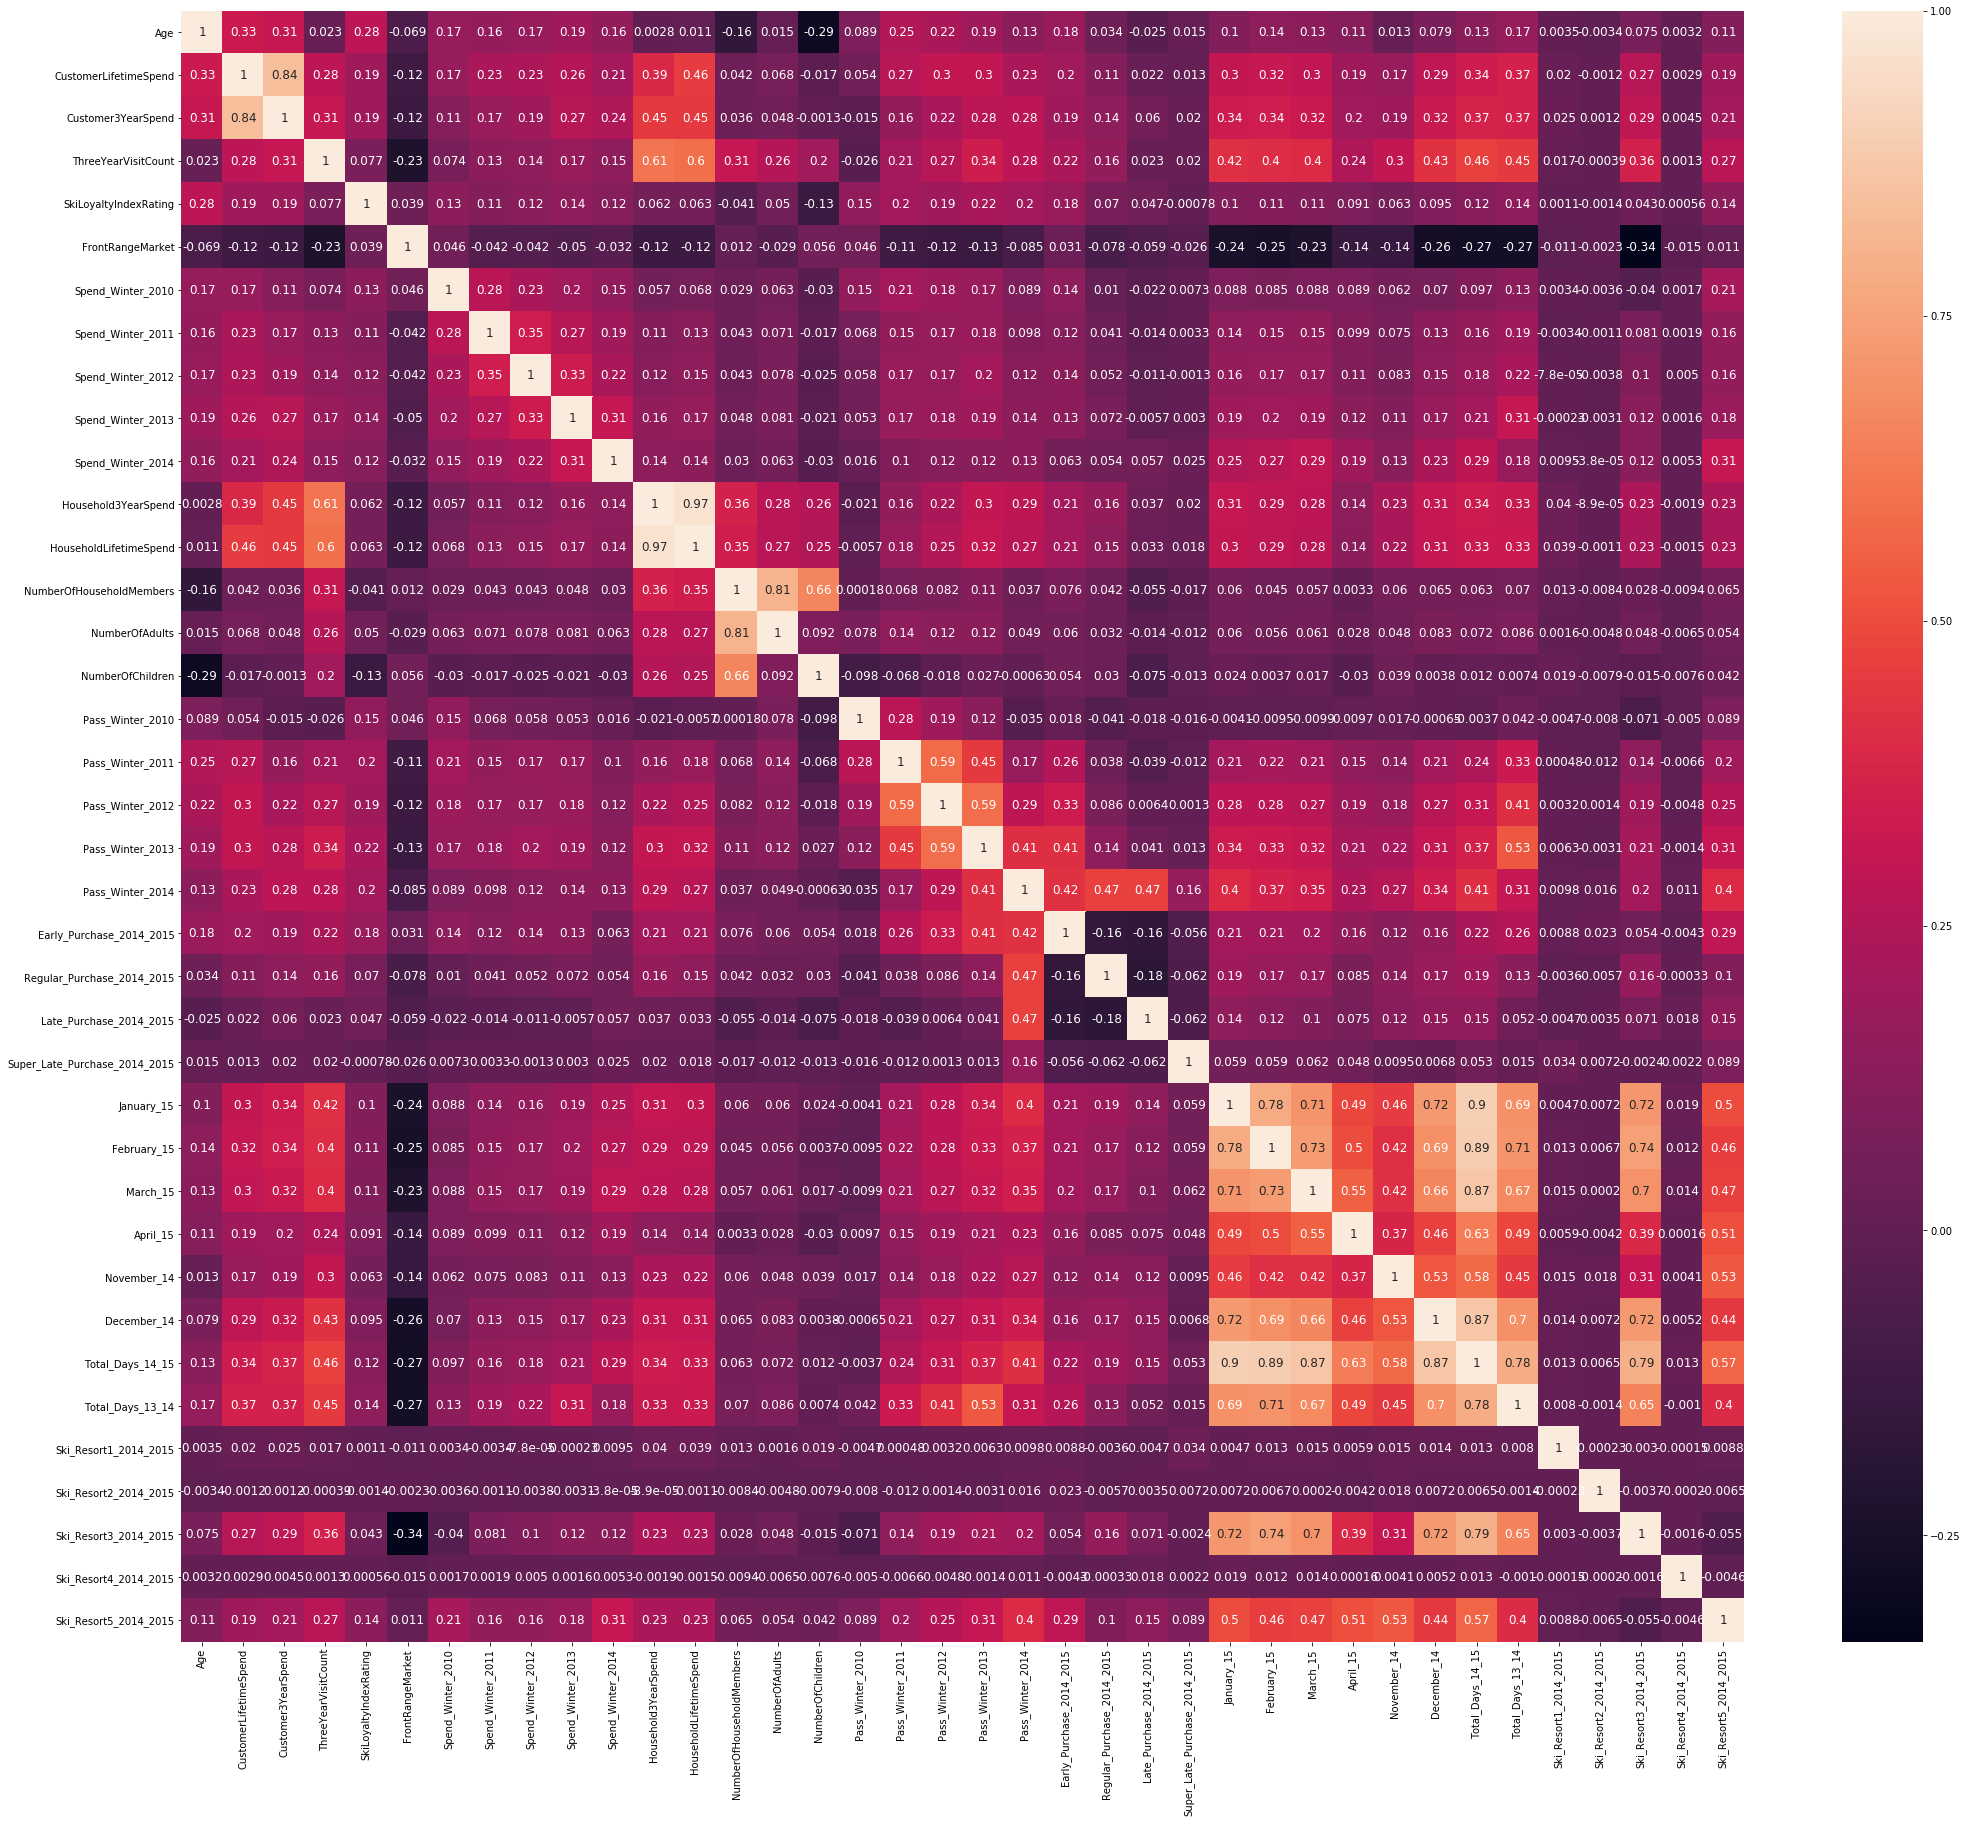

In [88]:
corr = df[cols].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(35,30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### There are a lot of features, so the Correlation Matrix is cramped, but as you can see from the list there are a number of features that have reasonably high correlation to the predictor and to each other. 

In [89]:
#pd.DataFrame(df[X]).to_csv('CO_2010_clean.csv', index=False)